In [2]:
from src import utils
imgs, labels = utils.load_imgs('../Wild Cats Dataset', ['CHEETAH' ,'OCELOT', 'SNOW LEOPARD', 'CARACAL', 'LIONS', 'PUMA', 'TIGER'])
x, y = utils.make_dataset(imgs, labels, utils.label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(x.shape, y.shape))
# utils.plot_sample(imgs, labels, 5, 5, resize=(224, 224))

Loaded 240 images of class CHEETAH
Loaded 238 images of class OCELOT
Loaded 236 images of class SNOW LEOPARD
Loaded 190 images of class CARACAL
Loaded 233 images of class LIONS
Loaded 241 images of class PUMA
Loaded 242 images of class TIGER
Loaded 1620 images total.
x shape: (1620, 224, 224, 3), y shape:(1620, 7)


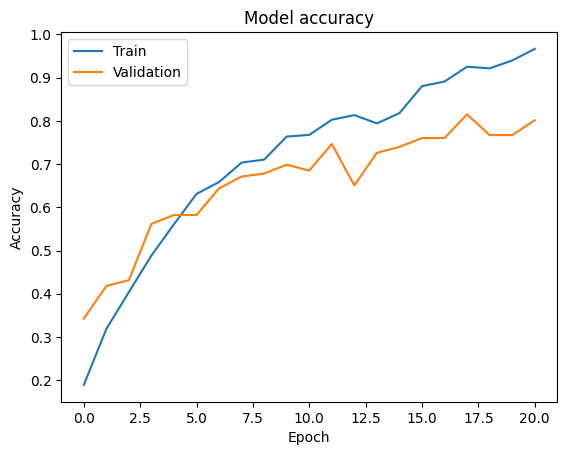

Test accuracy without image augmentation: 77.1605%


(T2): Model improved... saving new model


T = 9.5917: T2 model is better than T1


2023-06-05 23:26:59.199939: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:27:05.332341: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


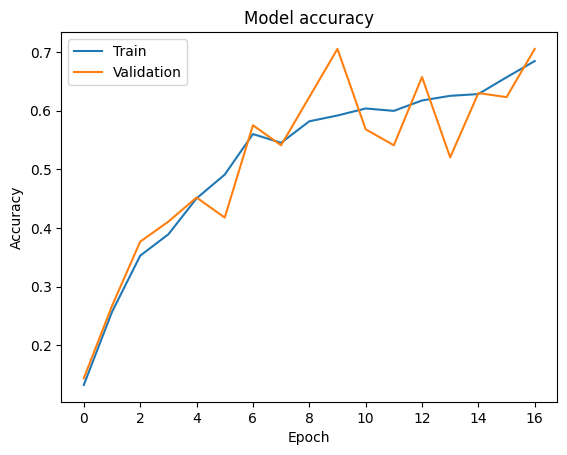


Test accuracy with Image Augmentation: 70.3704%


T = -2.0631: Model trained with image augmentation performs better


In [3]:
################### Task 2 ###################
# Solution go here
from src import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os
import warnings
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

# Ignores warnings
warnings.filterwarnings('ignore')

# ------- 1 -------
X = x / 255

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=42, shuffle=True)


# ------- 2 -------
# Creates the network
cNN = utils.create_cnn()

# ------- 3 -------
# Early Stopping callback. Restores best weights to save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the network
batch_size = 32
history = cNN.fit(x_train, y_train,
        steps_per_epoch=x_train.shape[0]//batch_size,
        epochs=50,
        validation_data=(x_val, y_val),
        validation_steps = 1,
        callbacks=[early_stopping],
        verbose=0)

# ------- 4 -------
# Plot the training history
utils.plot_history(history)

# Evaluate the model
_, accuracy = cNN.evaluate(x_test, y_test, verbose = 0)
print("Test accuracy without image augmentation: {:.4f}".format(accuracy * 100) + "%\n")

# Load the model saved from T2 (not the best)
file_path = '../deliverable/T2.h5'
best_model = utils.load_keras_model(file_path)
_, model_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

# Saves best model
if accuracy > model_accuracy or not os.path.isfile(file_path):
    print('\n(T2): Model improved... saving new model\n')
    utils.save_keras_model(cNN, file_path)

# ------ 5 -------
# Load the model to prepare the T-Test
T1_model = utils.load_keras_model('../deliverable/T1.h5')

T1_predictions = T1_model.predict(x_test, verbose = 0)
T2_predictions = cNN.predict(x_test, verbose = 0)

tt, p_val = utils.perform_paired_T_Test(T1_predictions, T2_predictions, y_test)

if - 1.96 < tt < 1.96:
  print('\nT = {:.4f}: NULL hypothesis is satisfied. T1 and T2 models are similar'.format(tt))
elif tt > 1.96:
  print('\nT = {:.4f}: T2 model is better than T1'.format(tt))
else:
  print('\nT = {:.4f}: T1 model is better than T2'.format(tt))

# ------ 6 -------
# Image augmentation
train_gen = ImageDataGenerator(channel_shift_range=0.3,
                               rotation_range=30,
                               zoom_range=0.3,
                               shear_range=15)

val_gen = ImageDataGenerator()

nr, nc = 5, 5

train_loader = train_gen.flow(x_train, y_train, batch_size=nr*nc)
val_loader = val_gen.flow(x_val, y_val, batch_size=x_val.shape[0])

# Creates the network again
cNN_img_aug = utils.create_cnn()

# Train the network again with augmented images
history = cNN_img_aug.fit(train_loader,
               steps_per_epoch=x_train.shape[0]//batch_size,
                epochs=70,
                validation_data=val_loader,
                validation_steps = 1,
                callbacks=[early_stopping],
                verbose=0)

utils.plot_history(history)

# Assess performance on the test set for the current model
_, accuracy = cNN_img_aug.evaluate(x_test, y_test, verbose = 0)
print("\nTest accuracy with Image Augmentation: {:.4f}".format(accuracy * 100) + "%\n")



# Prepare the T-Test
T2_predictions_img_aug = cNN_img_aug.predict(x_test, verbose = 0)

tt, p_val = utils.perform_paired_T_Test(T2_predictions, T2_predictions_img_aug, y_test)

if - 1.96 < tt < 1.96:
  print('\nT = {:.4f}: NULL hypothesis is satisfied. Models are similar'.format(tt))
elif tt > 1.96:
  print('\nT = {:.4f}: Model trained without image augmentation performs better'.format(tt))
else:
  print('\nT = {:.4f}: Model trained with image augmentation performs better'.format(tt))


In [4]:
################### Task 2 Bonus ###################
# Solution go here
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import warnings
import numpy as np
import tensorflow as tf
from src import utils

# Ignore warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

# Create the Convolutional NN
cnn = utils.create_cnn()

# Prepare the data
X = x / 255
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=42, shuffle=True)

# Image augmentation
train_gen = ImageDataGenerator(channel_shift_range=0.3,
                               rotation_range=30,
                               zoom_range=0.3,
                               shear_range=15)

val_gen = ImageDataGenerator()

nr, nc = 5, 5

train_loader = train_gen.flow(x_train, y_train, batch_size=nr*nc)
val_loader = val_gen.flow(x_val, y_val, batch_size=x_val.shape[0])

# Early Stopping callback. Restores best weights to save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Performs grid search
# Define the hyperparameter grid
param_grid = {
    'pool_size': [(4, 4), (5, 5)],
    'learning_rate': [0.001, 0.002],
    'neurons_dense1': [128, 64]
}

fit_params = {
    'steps_per_epoch': x_train.shape[0]//32,
    'epochs': 70,
    'validation_data': val_loader,
    'validation_steps': 1,
    'callbacks': [early_stopping],
    'verbose': 0
}

# Load best model from task 2
file_path = '../deliverable/T2_best_model.h5'
best_model = utils.load_keras_model(file_path)

_, best_score = best_model.evaluate(x_test, y_test)  # Using accuracy as the score
print("Best model's accuracy on test set: {:.4f}".format(best_score * 100) + "%\n")

best_params = None

for pool_size in param_grid['pool_size']:
    for learning_rate in param_grid['learning_rate']:
        for neurons in param_grid['neurons_dense1']:
            # Create the CNN model with current hyperparameters
            model = utils.create_cnn(pool_size = pool_size, learning_rate=learning_rate, neurons_dense1=neurons)
            # Fit the model
            model.fit(train_loader, **fit_params)
            # Evaluate the model
            _, score = model.evaluate(x_val, y_val)  # Using accuracy as the score
            # Update the best score and best parameters if necessary
            if score > best_score:
                best_score = score
                best_params = {
                    'pool_size': pool_size,
                    'learning_rate': learning_rate,
                    'neurons_dense1': neurons
                }
                print('\n(T2): Model improved... saving new best model\n')
                utils.save_keras_model(model, file_path)

print("Best Parameters:", best_params)
print("Best Score: {:.4f}".format(best_score * 100) + "%\n")

6/6 [==============================] - 0s 33ms/step - loss: 0.7494 - accuracy: 0.7654
Best model's accuracy on test set: 76.5432%



2023-06-05 21:25:48.738694: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:25:54.754529: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 36ms/step - loss: 0.5348 - accuracy: 0.7671

(T2): Model improved... saving new best model



2023-06-05 21:29:16.879806: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:29:22.755477: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 35ms/step - loss: 0.5834 - accuracy: 0.7877

(T2): Model improved... saving new best model



2023-06-05 21:33:02.068150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:33:07.977000: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 36ms/step - loss: 1.2043 - accuracy: 0.5342


2023-06-05 21:33:55.251895: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:34:00.988597: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 36ms/step - loss: 0.6110 - accuracy: 0.7808


2023-06-05 21:36:57.175192: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:37:02.775541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 32ms/step - loss: 1.1123 - accuracy: 0.6096


2023-06-05 21:38:06.214316: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:38:12.110695: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 32ms/step - loss: 0.7883 - accuracy: 0.7397


2023-06-05 21:39:49.840807: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:39:55.592051: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 33ms/step - loss: 0.9554 - accuracy: 0.6575


2023-06-05 21:41:28.233825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:41:33.868810: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 0s 32ms/step - loss: 1.0165 - accuracy: 0.5685
Best Parameters: {'pool_size': (4, 4), 'learning_rate': 0.001, 'neurons_dense1': 64}
Best Score: 78.7671%

